# Assignement 2 : The Exploration-Exploitation Dilemma

## 1 - Stochastic Multi-Armed Bandits on Simulated Data

### 1.1 Bernoulli bandit models

In [36]:
# Imports 
import numpy as np 
import arms
from tqdm import tqdm
import matplotlib.pyplot as plt
import random


In [2]:
# Defining our own Bernoulli bandit model with 4 arms 

# Random state
rs = np.random.randint(1, 312414)

# Bernouilli Bandit 
arm1 = arms.ArmBernoulli(0.50, random_state=rs)
arm2 = arms.ArmBernoulli(0.35, random_state=rs)
arm3 = arms.ArmBernoulli(0.40, random_state=rs)
arm4 = arms.ArmBernoulli(0.25, random_state=rs)

arm5 = arms.ArmBernoulli(0.45, random_state=rs)
arm6 = arms.ArmBernoulli(0.65, random_state=rs)
arm7 = arms.ArmBernoulli(0.15, random_state=rs)
arm8 = arms.ArmBernoulli(0.85, random_state=rs)

MAB1 = [arm1, arm2, arm3, arm4]
MAB2 = [arm5, arm6, arm7, arm8]


In [3]:
def sampled_reward(arm):
    """Get reward 1 if the arm is a Bernoulli arm 
    and 0 if it isn't
    """
    if isinstance(arm, arms.ArmBernoulli):
        return int(arm.sample())
    else:
        return int(arms.ArmBernoulli(arm))

In [4]:
def UCB1(T, MAB, rho=0.2 ):
    """
    Simulates a bandit game of length T with the UCB1 strategy on the bandit model MAB.
    Returns "rew": the sequence of the T rewards obtained
        and "draws":  the sequence the T the arms drawn.
    
    Parameters : 
    ==========
        T : int , Rounds
        MAB : list , List of arms 
        ro : float, 
    """ 
    # nbrA : number of arms
    nbrA = len(MAB)
    # List of the obtained rewards 
    rew = []
    # List of drawn arms 
    draws = []
    # Sum of arms rewards
    sum_rew = [0] * nbrA
    # Number of times each arm has been drawn 
    n_draws = [0] * nbrA
    
    # Initialise first phase : Play each arm once
    for i in range(nbrA):
        reward = sampled_reward(MAB[i])
        n_draws[i] += 1
        sum_rew[i] += reward
        draws.append(i)
        rew.append(reward)
        
    # Other drawings until time T
    for t in range(nbrA, T):
        # optimistic scores of the arms at time t
        optimistic_scores = np.array([sum_rew[a]/n_draws[a] + rho*np.sqrt(np.log(t)/(2*n_draws[a])) 
                           for a in range(nbrA)])

        # Pull arm
        # Arm to draw is the arm with the highest score 
        index_arm_draw = np.argmax(optimistic_scores)
        
        reward = sampled_reward(MAB[index_arm_draw])
        n_draws[index_arm_draw] += 1
        sum_rew[index_arm_draw] += reward
        draws.append(index_arm_draw)
        rew.append(reward)
    return rew, draws        

In [5]:
def TS(T,MAB):
    """    
    Simulates a bandit game of length T with the Thompson Sampling strategy on the bandit model MAB.
    Returns "rew": the sequence of the T rewards obtained
        and "draws": the sequence the T the arms drawn.
    
    Parameters : 
    ==========
        T : int, Rounds
        MAB : list, List of arms 
    """ 
    # nbrA : number of arms
    nbrA = len(MAB)
    # List of the obtained rewards 
    rew = []
    # List of drawn arms 
    draws = []
    # Sum of arms rewards
    sum_rew = [0] * nbrA
    # Number of times each arm has been drawn 
    n_draws = [0] * nbrA
    
    for t in range(T):
        # posterior distributions
        scores = [np.random.beta(sum_rew[a] + 1, n_draws[a] - sum_rew[a] + 1) 
                  for a in range(nbrA)]
        # Pull arm
        # Arm to draw is the arm with the highest score 
        index_arm_draw = np.argmax(scores)
        
        reward = sampled_reward(MAB[index_arm_draw])
        n_draws[index_arm_draw] += 1
        sum_rew[index_arm_draw] += reward
        draws.append(index_arm_draw)
        rew.append(reward)
    return rew, draws 

In [6]:
def NaiveStrat(T, MAB):
    """    
    Simulates a bandit game of length T with the Naive strategy on the bandit model MAB.
    Returns "rew": the sequence of the T rewards obtained
        and "draws": the sequence the T the arms drawn.
    
    Parameters : 
    ==========
        T : int, Rounds
        MAB : list, List of arms 
    """
    # nbrA : number of arms
    nbrA = len(MAB)
    # List of the obtained rewards 
    rew = []
    # List of drawn arms 
    draws = []
    # Sum of arms rewards
    sum_rew = [0] * nbrA
    # Number of times each arm has been drawn 
    n_draws = [0] * nbrA
    
    # Initialise first phase : Play each arm once
    for i in range(nbrA):
        reward = sampled_reward(MAB[i])
        n_draws[i] += 1
        sum_rew[i] += reward
        draws.append(i)
        rew.append(reward)
        
    # Other drawings until time T
    for t in range(nbrA, T):
        # Empirical best arm 
        scores = np.array([sum_rew[a]/n_draws[a] for a in range(nbrA)])
        # Pull arm
        # Arm to draw is the arm with the highest score 
        index_arm_draw = np.argmax(scores)
        
        reward = sampled_reward(MAB[index_arm_draw])
        n_draws[index_arm_draw] += 1
        sum_rew[index_arm_draw] += reward
        draws.append(index_arm_draw)
        rew.append(reward)
    return rew, draws  

In [7]:
"""Simulating a bandit game of length T with the UCB1 and Thompson Sampling
strategy on the bandit model MAB: rew and draws are the sequence of the
T rewards obtained and of the T the arms drawn."""
T = 5000  # horizon

rew1, draws1 = UCB1(T, MAB1)
rew2, draws2 = TS(T, MAB1)
rew3, draws3 = NaiveStrat(T, MAB1)


In [8]:
def expected_regret(MAB, T, strategy, N):
    """Based on many simulations on the MAB for a given strategy, 
    it computes the mean regrets at each time.
    It returns an array of mean regrets at each t in range(T)
    
    Parameters :
    ===========
    MAB : list, list of arms 
    T : int, Time horizon
    strategy : str, "UCB1" or "TS" ( Thompson Sampling)
    N : int, number of simulations 
    """
    # best arm
    means = [el.mean for el in MAB]
    mu_max = np.max(means)
    
    
    reg = np.zeros((N, T))
    rew = np.zeros(T)
    draws = np.zeros(T)

    for k in tqdm(range(N), desc="Simulating {}".format(strategy)):
        if strategy == "UCB1":
            rew1, draws1 = UCB1(T, MAB)
            reg[k, :] = mu_max * np.arange(1, T + 1) - np.cumsum(rew1) 
        
        elif strategy == "TS":
            rew2, draws2 = TS(T, MAB)
            reg[k, :] = mu_max * np.arange(1, T + 1) - np.cumsum(rew2)
        
        elif strategy == "NaiveStrat":
            rew3, draws3 == NaiveStrat(T, MAB)
            reg[k, :] =  mu_max * np.arange(1, T + 1) - np.cumsum(rew3) 
            
    mean_regret = np.mean(reg, axis = 0)
    return mean_regret

In [9]:
def kl(x, y):
    return x*np.log(x/y) + (1-x)*np.log((1-x)/(1-y))

def problem_complexity(MAB):
    means = [arm.mean for arm in MAB]
    p1 = max(means)
    c = sum((p1-p)/(kl(p, p1)) for p in means if p != p1)
    return c
    

#### Question 1:

In [10]:
""" Based on many simulations, estimate the expected regret of 
UCB1 and Thompson Sampling """
N = 100  # number of simulations 
# The expected regret of UCB1
print ("The expected regret of UCB1 after {} simulations : ".format(N))
reg1 = expected_regret(MAB1, T, "UCB1", N)
print(reg1)
# The expected regret of Thompson Sampling
print ("The expected regret of Thompson Sampling after {} simulations : ".format(N))
reg2 = expected_regret(MAB1, T, "TS", N)
print(reg2)
# The expected regret of Naive strategy
print ("The expected regret of Naive strateg after {} simulations : ".format(N))
reg3 = expected_regret(MAB1, T, "NaiveStrat", N)
print(reg3)

Simulating UCB1:   1%|          | 1/100 [00:00<00:14,  6.96it/s]

The expected regret of UCB1 after 100 simulations : 


Simulating TS:   2%|▏         | 2/100 [00:00<00:08, 11.18it/s]

[6.0000e-02 2.5000e-01 3.7000e-01 ... 1.8390e+02 1.8390e+02 1.8391e+02]
The expected regret of Thompson Sampling after 100 simulations : 


Simulating NaiveStrat:   2%|▏         | 2/100 [00:00<00:05, 18.70it/s]

[ 0.1   0.21  0.23 ... 48.23 48.27 48.18]
The expected regret of Naive strateg after 100 simulations : 


Simulating NaiveStrat: 100%|██████████| 100/100 [00:05<00:00, 17.25it/s]

[5.000e-01 0.000e+00 5.000e-01 ... 7.670e+02 7.665e+02 7.670e+02]


Problem 1 with complexity : 10.159725560246056


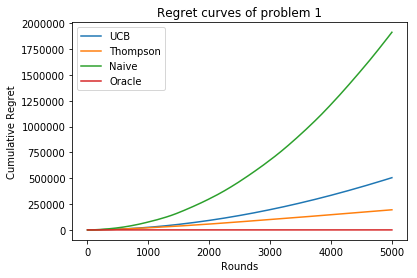

In [12]:
"""Display regret curves for problem 1"""

x = np.arange(1, T+1)
c = problem_complexity(MAB1)
oracle = [c*np.log(t) for t in x]

print("Problem 1 with complexity :", c)
plt.figure(1)


plt.plot(x, reg1.cumsum(), label='UCB')
plt.plot(x, reg2.cumsum(), label='Thompson')
plt.plot(x, reg3.cumsum(), label='Naive')
plt.plot(x, oracle, label='Oracle')
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Regret curves of problem 1')
plt.show()

In [13]:
""" Based on many simulations, estimate the expected regret of 
UCB1 and Thompson Sampling """
# The expected regret of UCB1
print ("The expected regret of UCB1 after {} simulations : ".format(N))
reg1 = expected_regret(MAB2, T, "UCB1", N)
print(reg1)
# The expected regret of Thompson Sampling
print ("The expected regret of Thompson Sampling after {} simulations : ".format(N))
reg2 = expected_regret(MAB2, T, "TS", N)
print(reg2)
# The expected regret of Naive strategy
print ("The expected regret of Naive strateg after {} simulations : ".format(N))
reg3 = expected_regret(MAB2, T, "NaiveStrat", N)
print(reg3)

Simulating UCB1:   1%|          | 1/100 [00:00<00:12,  8.21it/s]

The expected regret of UCB1 after 100 simulations : 


Simulating TS:   2%|▏         | 2/100 [00:00<00:08, 11.20it/s]

[  0.38   0.58   1.36 ... 196.74 196.82 196.93]
The expected regret of Thompson Sampling after 100 simulations : 


Simulating NaiveStrat:   2%|▏         | 2/100 [00:00<00:08, 11.57it/s]

[ 0.24  0.56  0.91 ... 22.01 22.08 22.04]
The expected regret of Naive strateg after 100 simulations : 


Simulating NaiveStrat: 100%|██████████| 100/100 [00:05<00:00, 18.61it/s]

[8.50000e-01 7.00000e-01 1.55000e+00 ... 2.51630e+03 2.51615e+03
 2.51700e+03]


Problem 2 with complexity : 3.147078426264685


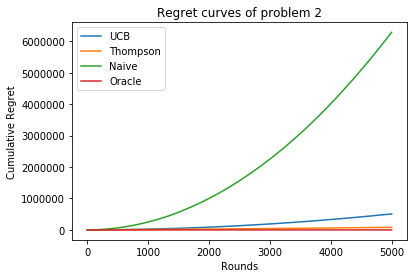

In [14]:
"""Display regret curves for problem 2"""

c = problem_complexity(MAB2)
oracle = [c*np.log(t) for t in x]

print("Problem 2 with complexity :", c)
plt.figure(1)
x = np.arange(1, T+1)

plt.plot(x, reg1.cumsum(), label='UCB')
plt.plot(x, reg2.cumsum(), label='Thompson')
plt.plot(x, reg3.cumsum(), label='Naive')
plt.plot(x, oracle, label='Oracle')
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Regret curves of problem 2')
plt.show()

The two plots shows that the cumulative regret for UCB1 and Thompson strategies are always greater than the Lai and Robbins lower bound.
We notice also that in two problems, UCB strategy has always greater cumulative regret than Thompson strategy.
In the more complex problem ( problem 1), the UCB and Thompson strategies has greater cumulative regret than the naive strategy, but on the less complex problem ( problem 2) we see the inverse. 

### 1.2 Non-parametric bandits (bounded rewards)


#### Question 2 :
The method of Thompson sampling isn't very suited to arms that take non-binary values. 
To make it works on the non-parametric bandits, we redefined the sampled_reward function used in the algorithm of UCB1 and Thompson sampling. 
The notion of complexity doesn't make sense anymore, because KL involvec in the computation of the complexity is only calculated for Bernouilli variables.


In [15]:
# Redefinition of the sampled_reward function 
def sampled_reward(arm):
    if isinstance(arm, arms.ArmBernoulli):
        return int(arm.sample())
    else:
        a = arm.sample()
        b = arms.ArmBernoulli(a)
        return int(b.sample())



In [16]:
# Non-parametric bandits

# Random state
rs = np.random.randint(1, 312414)

arm1 = arms.ArmBernoulli(0.50, random_state=rs)
arm2 = arms.ArmBeta(0.35, 0.2, random_state=rs)
arm3 = arms.ArmExp(L=1, random_state=rs)
arm4 = arms.ArmExp(L=1.5, random_state=rs)

MAB = [arm1, arm2, arm3, arm4]



In [17]:
N = 100  # number of simulations 
# The expected regret of UCB1
print ("The expected regret of UCB1 after {} simulations : ".format(N))
reg1 = expected_regret(MAB, T, "UCB1", N)
print(reg1)
# The expected regret of Thompson Sampling
print ("The expected regret of Thompson Sampling after {} simulations : ".format(N))
reg2 = expected_regret(MAB, T, "TS", N)
print(reg2)
# The expected regret of Naive strategy
print ("The expected regret of Naive strateg after {} simulations : ".format(N))
reg3 = expected_regret(MAB, T, "NaiveStrat", N)
print(reg3)

The expected regret of UCB1 after 100 simulations : 


Simulating TS:   1%|          | 1/100 [00:00<00:15,  6.52it/s]

[1.16363636e-01 1.42727273e-01 4.39090909e-01 ... 3.29955455e+02
 3.30071818e+02 3.30058182e+02]
The expected regret of Thompson Sampling after 100 simulations : 


Simulating NaiveStrat:   1%|          | 1/100 [00:00<00:17,  5.70it/s]

[ 0.23636364  0.44272727  0.60909091 ... 79.59545455 79.58181818
 79.58818182]
The expected regret of Naive strateg after 100 simulations : 


Simulating NaiveStrat: 100%|██████████| 100/100 [00:10<00:00,  9.78it/s]

[6.36363636e-01 2.72727273e-01 9.09090909e-01 ... 1.44854545e+03
 1.44818182e+03 1.44881818e+03]


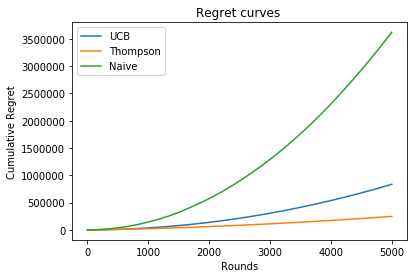

In [18]:
"""Display regret curves"""

plt.figure(1)
x = np.arange(1, T+1)
plt.plot(x, reg1.cumsum(), label='UCB')
plt.plot(x, reg2.cumsum(), label='Thompson')
plt.plot(x, reg3.cumsum(), label='Naive')
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.title('Regret curves ')
plt.show()

The naive strategy has the greatest cumulative regret, and the Thompson strategy has the smallest cumulative regret.

## 2 - Linear Bandit on Real Data

### 2.1 - Linear Bandit

In [20]:
from linearmab_models import ToyLinearModel, ColdStartMovieLensModel

random_state = np.random.randint(0, 24532523)

model = ColdStartMovieLensModel(random_state=random_state,noise=0.1)


In [29]:
def optimal_arm(model, X, alpha, theta_hat):
    """ Returns the optimal arm """
    A = np.dot(model.features, theta_hat) 
    B = alpha*np.sqrt(np.diagonal(np.dot(model.features, np.linalg.inv(X)).dot(model.features.T)))
    return np.argmax(A + B) 

def linUCB(model, T, nb_simu, alpha, lamb):
    """   """
    regret = np.zeros((nb_simu, T)) # regret at each iteration 
    norm_dist = np.zeros((nb_simu, T)) # 
    nbrF = model.n_features # number of features 

    for k in tqdm(range(nb_simu), desc="Simulating LinUCB "):
        
        # Initialization 
        X = lamb*np.identity(nbrF)   # Z_t.T*Z_t + lambda*Id
        Y = np.zeros(nbrF)  #Z_t.T*y_t
        
        
        for t in range(T):
            theta_hat = np.dot(np.linalg.inv(X),Y)
            
            a_t = optimal_arm(model, X, alpha, theta_hat)  # optimal action
            r_t = model.reward(a_t) # get the reward

            F = model.features[a_t, :].reshape(-1,1)
            X += F.dot(F.T)
            Y += r_t*F.flatten()

            # store regret
            regret[k, t] = model.best_arm_reward() - r_t
            norm_dist[k, t] = np.linalg.norm(theta_hat - model.real_theta, 2)

    # compute average (over sim) of the algorithm performance and plot it
    mean_norms =  np.mean(norm_dist, axis = 0)
    mean_regrets = np.mean(regret, axis = 0)
    
    return mean_regrets, mean_norms


In [33]:
def Random_policy(model, T, nb_simu, lamb):
    """   """
    regret = np.zeros((nb_simu, T)) # regret at each iteration 
    norm_dist = np.zeros((nb_simu, T)) # 
    nbrF = model.n_features # number of features 

    for k in tqdm(range(nb_simu), desc="Simulating Random policy "):
        
        # Initialization 
        X = lamb*np.identity(nbrF)   # Z_t.T*Z_t + lambda*Id
        Y = np.zeros(nbrF)  #Z_t.T*y_t
        
        
        for t in range(T):
            theta_hat = np.dot(np.linalg.inv(X),Y)
            
            a_t = np.random.randint(model.n_actions)  # random arm
            r_t = model.reward(a_t) # get the reward

            F = model.features[a_t, :].reshape(-1,1)
            X += F.dot(F.T)
            Y += r_t*F.flatten()

            # store regret
            regret[k, t] = model.best_arm_reward() - r_t
            norm_dist[k, t] = np.linalg.norm(theta_hat - model.real_theta, 2)

    # compute average (over sim) of the algorithm performance and plot it
    mean_norms =  np.mean(norm_dist, axis = 0)
    mean_regrets = np.mean(regret, axis = 0)
    
    return mean_regrets, mean_norms

    

In [34]:
def epsilon_greedy(model, T, nb_simu, epsilon, lamb):
    """   """
    regret = np.zeros((nb_simu, T)) # regret at each iteration 
    norm_dist = np.zeros((nb_simu, T)) # 
    nbrF = model.n_features # number of features 

    for k in tqdm(range(nb_simu), desc="Simulating $\epsilon$-greedy "):
        
        # Initialization 
        X = lamb*np.identity(nbrF)   # Z_t.T*Z_t + lambda*Id
        Y = np.zeros(nbrF)  #Z_t.T*y_t
        
        
        for t in range(T):
            theta_hat = np.dot(np.linalg.inv(X),Y)
            
            # chooses a random arm with probability epsilon and the optimal
            # arm with probability 1-epsilon
            r = random.random()
            if r < epsilon:
                a_t = np.random.randint(model.n_actions)
            else:
                a_t = np.argmax(np.dot(model.features, theta_hat))
            
            r_t = model.reward(a_t) # get the reward

            F = model.features[a_t, :].reshape(-1,1)
            X += F.dot(F.T)
            Y += r_t*F.flatten()

            # store regret
            regret[k, t] = model.best_arm_reward() - r_t
            norm_dist[k, t] = np.linalg.norm(theta_hat - model.real_theta, 2)

    # compute average (over sim) of the algorithm performance and plot it
    mean_norms =  np.mean(norm_dist, axis = 0)
    mean_regrets = np.mean(regret, axis = 0)
    
    return mean_regrets, mean_norms



In [37]:
T = 6000
nb_simu = 50
alpha = 2
lamb = 1
epsilon = 0.1

mean_regrets1, mean_norm1 = linUCB(model, T, nb_simu, alpha, lamb)
mean_regrets2, mean_norm2 = Random_policy(model, T, nb_simu, lamb)
mean_regrets3, mean_norm3 = epsilon_greedy(model, T, nb_simu, epsilon, lamb)

Simulating $\epsilon$-greedy : 100%|██████████| 50/50 [00:48<00:00,  1.52it/s]


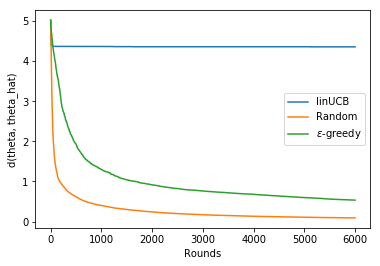

In [44]:

plt.plot(mean_norm1, label='linUCB')
plt.plot(mean_norm2, label='Random')
plt.plot(mean_norm3, label='$\epsilon$-greedy')
plt.ylabel('d(theta, theta_hat)')
plt.xlabel('Rounds')
plt.legend()



The random strategy converges faster than the other strategies. The linUCB algorithm doesn't converge to the real $\theta$.

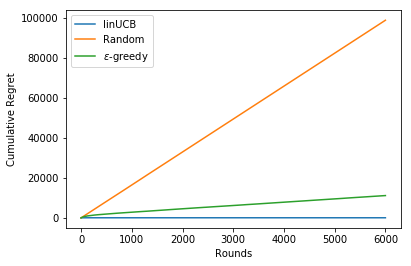

In [51]:
plt.plot(mean_regrets1.cumsum(), label='linUCB')
plt.plot(mean_regrets2.cumsum(), label='Random')
plt.plot(mean_regrets3.cumsum(), label='$\epsilon$-greedy')
plt.ylabel('Cumulative Regret')
plt.xlabel('Rounds')
plt.legend()
plt.show()

The linUCB has the lower cumulative regrets. And the random strategy has the highest cumulative regret. 